
# ADS 505 — Team Technical Notebook (Cleaned + Results Summary + Profit Table)

**GitHub repository:** (add your team repo link here)  
**Dataset:** Vehicle Insurance (train.csv, test.csv, sample_submission.csv)  
**Audience:** technical peers. Comments are short and human.

What's new:
- Robust data-quality audit & cleaning (hidden nulls -> NaN, trim, numeric coercion, drop dupes).
- Results summary cell under metrics (plain English).
- Profit table helper to turn Top-K into dollars for your 2-week A/B.



## 1) Problem statement & justification
Goal: Rank customers by probability of purchasing vehicle insurance so the business can contact only the top-K% each day and improve ROI.

Why this matters: Outreach has a cost and limited capacity. Ordering by risk focuses effort where it pays off.


## 2) Setup & raw data load

In [4]:

import warnings, os, numpy as np, pandas as pd, matplotlib.pyplot as plt, re
warnings.filterwarnings('ignore')
RANDOM_STATE = 42
pd.set_option('display.max_columns', 120)

TRAIN_PATH = 'train.csv'
TEST_PATH  = 'test.csv'
SUB_PATH   = 'sample_submission.csv'

train_raw = pd.read_csv(TRAIN_PATH)
test_raw  = pd.read_csv(TEST_PATH)
sub       = pd.read_csv(SUB_PATH)

# Identify target
target_col = 'Response' if 'Response' in train_raw.columns else train_raw.columns[-1]

print('Raw shapes -> train:', train_raw.shape, '| test:', test_raw.shape, '| sub:', sub.shape)
print('Target column:', target_col)
display(train_raw.head())


Raw shapes -> train: (381109, 12) | test: (127037, 11) | sub: (127037, 2)
Target column: Response


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 3) Data-quality audit (pre-clean)

In [6]:

def dq_audit(df, name='df'):
    print(f"\n=== Data Quality Audit: {name} ===")
    print("Shape:", df.shape)
    print("Dtypes (count):\n", df.dtypes.value_counts())
    miss = df.isna().sum().sort_values(ascending=False)
    print("\nMissing (NaN) — top 15:\n", miss.head(15))

    NULL_LIKE = {"", " ", "NA", "N/A", "na", "n/a", "NaN", "nan", "NULL", "Null", "null", "?", "Unknown", "UNKNOWN", "unknown"}
    counts = {}
    for c in df.columns:
        if df[c].dtype == 'O':
            vc = df[c].isin(NULL_LIKE).sum()
            if vc:
                counts[c] = int(vc)
    if counts:
        print("\nHidden-null tokens (count per column):", counts)
    else:
        print("\nHidden-null tokens: none detected in object columns.")
    dups = df.duplicated().sum()
    print("Duplicate rows:", dups)
    return miss

_ = dq_audit(train_raw, "train (raw)")
_ = dq_audit(test_raw,  "test (raw)")



=== Data Quality Audit: train (raw) ===
Shape: (381109, 12)
Dtypes (count):
 int64      6
object     3
float64    3
Name: count, dtype: int64

Missing (NaN) — top 15:
 id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Hidden-null tokens: none detected in object columns.
Duplicate rows: 0

=== Data Quality Audit: test (raw) ===
Shape: (127037, 11)
Dtypes (count):
 int64      5
object     3
float64    3
Name: count, dtype: int64

Missing (NaN) — top 15:
 id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintag

## 4) Cleaning: standardize hidden nulls, trim, coerce numerics, drop dupes

In [8]:

NULL_LIKE = {"", " ", "NA", "N/A", "na", "n/a", "NaN", "nan", "NULL", "Null", "null", "?", "Unknown", "UNKNOWN", "unknown"}

def looks_numeric_series(s: pd.Series, sample_n=50):
    s = s.dropna().astype(str)
    if s.empty: 
        return False
    sample = s.sample(min(sample_n, len(s)), random_state=42)
    noise = sample.str.replace(r"[0-9\.\-]", "", regex=True).str.len().mean()
    return noise < 0.2

def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    obj_cols = df.select_dtypes(include=['object']).columns
    for c in obj_cols:
        df[c] = df[c].astype(str).str.strip()

    for c in obj_cols:
        df.loc[df[c].isin(NULL_LIKE), c] = np.nan

    obj_as_num = [c for c in obj_cols if looks_numeric_series(df[c])]
    for c in obj_as_num:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    df = df.drop_duplicates(ignore_index=True)
    return df

train = clean_df(train_raw)
test  = clean_df(test_raw)

print("After cleaning shapes -> train:", train.shape, "| test:", test.shape)


After cleaning shapes -> train: (381109, 12) | test: (127037, 11)


## 5) Data-quality audit (post-clean)

In [10]:

_ = dq_audit(train, "train (clean)")
_ = dq_audit(test,  "test (clean)")



=== Data Quality Audit: train (clean) ===
Shape: (381109, 12)
Dtypes (count):
 int64      6
object     3
float64    3
Name: count, dtype: int64

Missing (NaN) — top 15:
 id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Hidden-null tokens: none detected in object columns.
Duplicate rows: 0

=== Data Quality Audit: test (clean) ===
Shape: (127037, 11)
Dtypes (count):
 int64      5
object     3
float64    3
Name: count, dtype: int64

Missing (NaN) — top 15:
 id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vi

### Optional sanity checks (domain-specific)

In [12]:

def sanity_checks(df):
    issues = {}
    def flag(col, cond, msg):
        n = cond.sum()
        if n:
            issues.setdefault(col, []).append((msg, int(n)))

    cols = df.columns
    if "Age" in cols and pd.api.types.is_numeric_dtype(df["Age"]):
        flag("Age", (df["Age"] < 0) | (df["Age"] > 120), "Age out of range")
    if "Vintage" in cols and pd.api.types.is_numeric_dtype(df["Vintage"]):
        flag("Vintage", df["Vintage"] < 0, "Vintage negative")
    if "Annual_Premium" in cols and pd.api.types.is_numeric_dtype(df["Annual_Premium"]):
        flag("Annual_Premium", df["Annual_Premium"] <= 0, "Premium non-positive")
    if "Previously_Insured" in cols and pd.api.types.is_numeric_dtype(df["Previously_Insured"]):
        flag("Previously_Insured", ~df["Previously_Insured"].isin([0,1]), "Expected 0/1")
    if "Vehicle_Age" in cols and df["Vehicle_Age"].dtype == "O":
        allowed = {"< 1 Year", "1-2 Year", "> 2 Years"}
        flag("Vehicle_Age", ~df["Vehicle_Age"].isin(allowed), "Unexpected category")

    if issues:
        print("\nSanity check issues (column -> [(issue, count)]):")
        for k,v in issues.items():
            print(f"  {k}: {v}")
    else:
        print("\nSanity checks: no obvious issues.")

sanity_checks(train)



Sanity checks: no obvious issues.


## 6) Save cleaned files (reproducible inputs for pipeline)

In [14]:

train.to_csv("train_clean.csv", index=False)
test.to_csv("test_clean.csv", index=False)
print("Saved: train_clean.csv, test_clean.csv")


Saved: train_clean.csv, test_clean.csv


## 7) Quick EDA on cleaned data

Target rate (clean): 0.1226


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


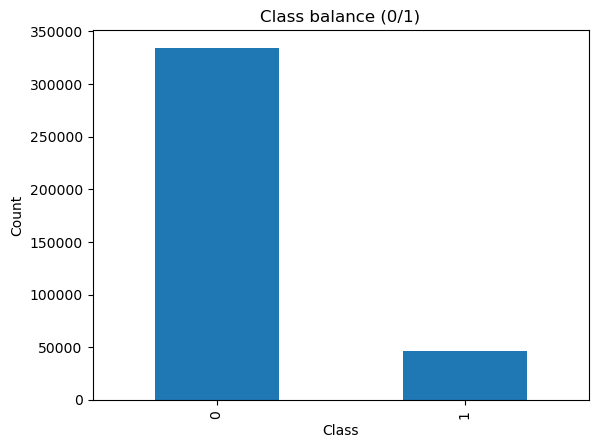

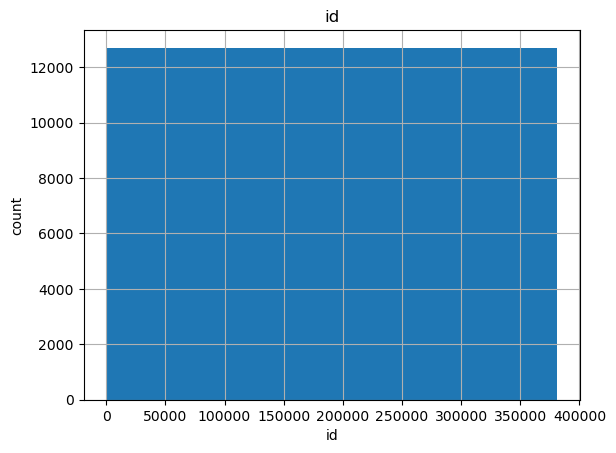

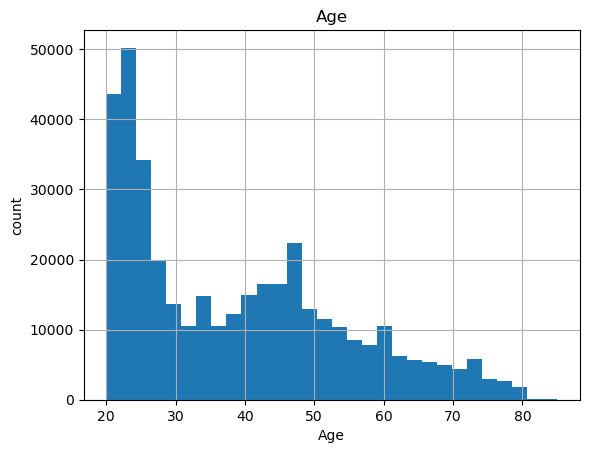

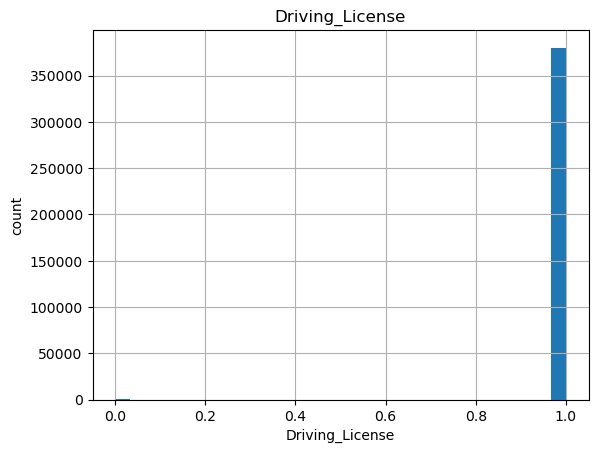

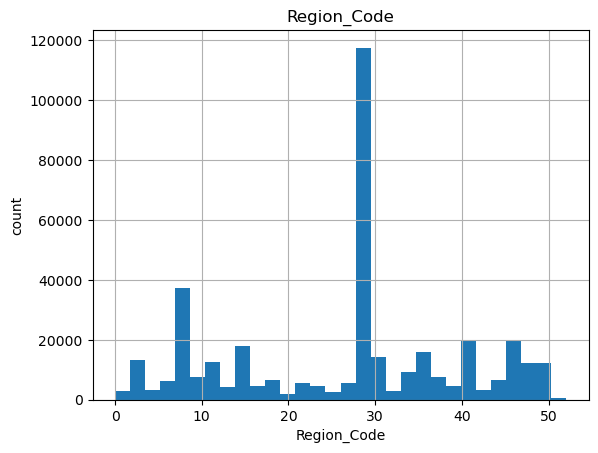

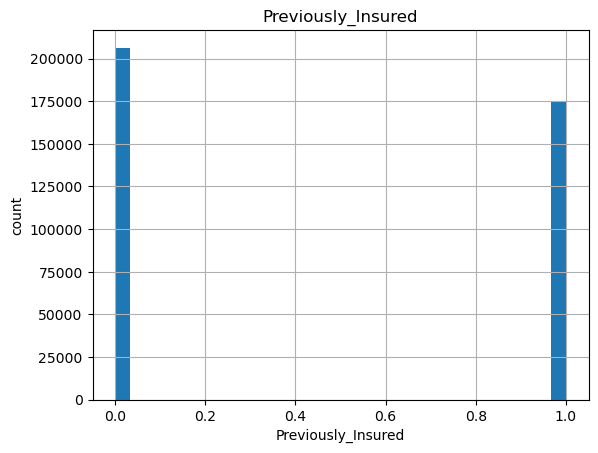

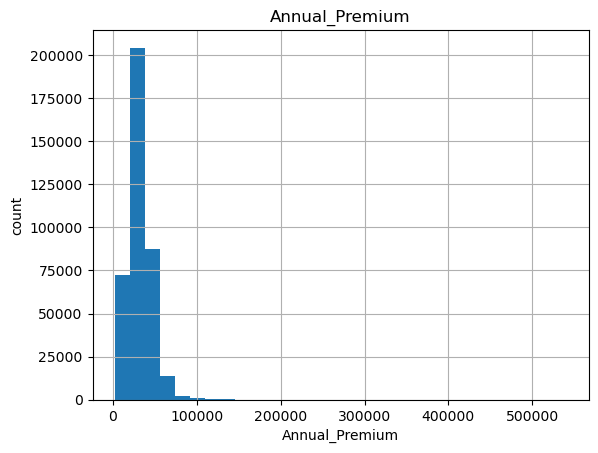

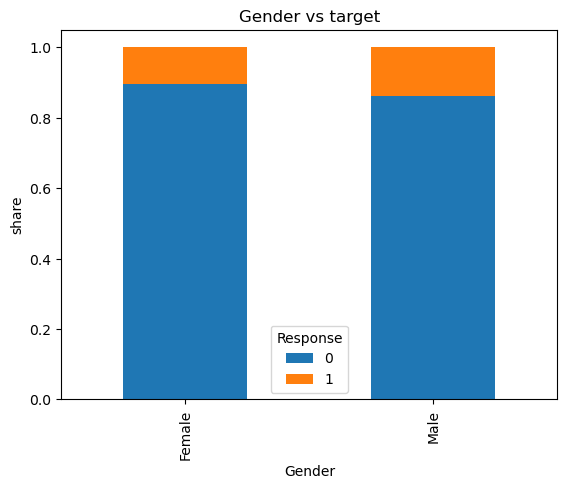

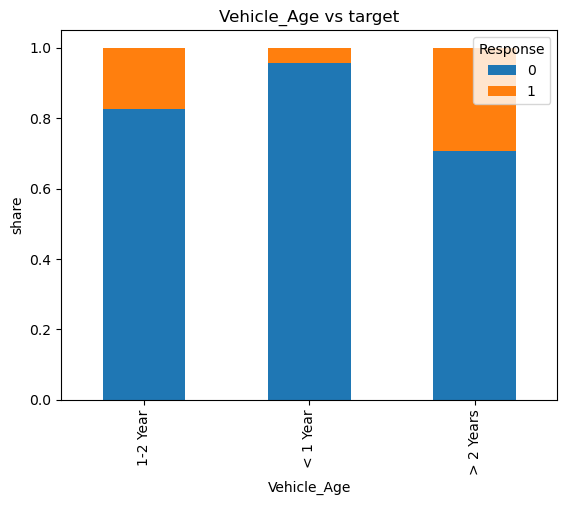

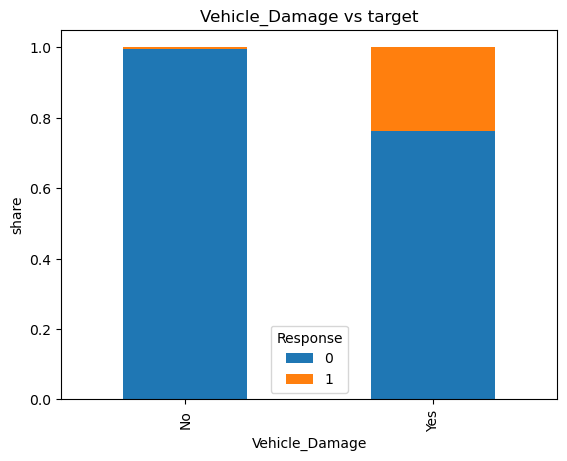

In [16]:

y = train[target_col]
X = train.drop(columns=[target_col])

print('Target rate (clean):', round(y.mean(), 4))
display(train.head())

y.value_counts().plot(kind='bar'); plt.title('Class balance (0/1)'); plt.xlabel('Class'); plt.ylabel('Count'); plt.show()

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
for col in num_cols[:6]:
    X[col].hist(bins=30); plt.title(col); plt.xlabel(col); plt.ylabel('count'); plt.show()

cat_cols = [c for c in X.columns if c not in num_cols]
for col in cat_cols[:4]:
    tmp = pd.crosstab(X[col], y, normalize='index')
    tmp.plot(kind='bar', stacked=True); plt.title(f'{col} vs target'); plt.ylabel('share'); plt.show()


## 8) Preprocessing pipeline (impute + scale + one-hot)

In [18]:

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False)),
])

try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', ohe),
])

preprocess = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols),
])

print('Numeric:', len(num_cols), '| Categorical:', len(cat_cols))


Numeric: 8 | Categorical: 3


## 9) Train/validation split (stratified)

In [20]:

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print('Train/Val shapes:', X_train.shape, X_val.shape)
print('Target rate (train/val):', round(y_train.mean(),4), round(y_val.mean(),4))


Train/Val shapes: (304887, 11) (76222, 11)
Target rate (train/val): 0.1226 0.1226


## 10) Model strategies & evaluation


Research questions
- Which baseline gives the best ranking by AUC / PR-AUC?
- For realistic capacity, what Top-K% cutoff gives the best lift?
- Are probabilities well-calibrated (optional later)?


In [23]:

from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
import numpy as np

def metric_summary(y_true, proba, thr=0.5):
    y_pred = (proba>=thr).astype(int)
    return {
        'AUC': roc_auc_score(y_true, proba),
        'PR-AUC': average_precision_score(y_true, proba),
        'F1@0.5': f1_score(y_true, y_pred, zero_division=0),
        'Acc@0.5': accuracy_score(y_true, y_pred)
    }

def top_k_capture(y_true, proba, k=0.2):
    n = len(y_true); k_n = max(1, int(k*n))
    order = np.argsort(-proba)
    return np.array(y_true)[order][:k_n].sum() / max(1, np.sum(y_true))

models = {
    'LogReg': LogisticRegression(max_iter=200, class_weight='balanced', random_state=42),
    'RF': RandomForestClassifier(n_estimators=300, min_samples_split=10, min_samples_leaf=3,
                                class_weight='balanced_subsample', n_jobs=-1, random_state=42),
    'GB': GradientBoostingClassifier(random_state=42)
}

results = {}
lift_at = [0.10, 0.20, 0.30]
best_name, best_auc, best_proba, best_lifts = None, -1, None, {}

for name, clf in models.items():
    pipe = Pipeline([('pre', preprocess), ('clf', clf)]).fit(X_train, y_train)
    proba = pipe.predict_proba(X_val)[:,1]
    metrics = metric_summary(y_val, proba)
    results[name] = metrics
    print(name, metrics)
    model_lifts = {}
    for k in lift_at:
        cap = top_k_capture(y_val, proba, k)
        model_lifts[k] = (cap, cap/k)
        print(f'  Lift@Top{k*100:.0f}% ~ {cap/k:.2f}x (captures {cap:.1%} of buyers)')
    if metrics['AUC'] > best_auc:
        best_auc, best_name, best_proba, best_lifts = metrics['AUC'], name, proba, model_lifts

print('\nSelected ranking model by AUC:', best_name, '| AUC =', round(best_auc, 4))
best_name, best_lifts


LogReg {'AUC': 0.8385069015502352, 'PR-AUC': 0.3225951024202755, 'F1@0.5': 0.399262818403212, 'Acc@0.5': 0.6407730051691113}
  Lift@Top10% ~ 2.90x (captures 29.0% of buyers)
  Lift@Top20% ~ 2.73x (captures 54.6% of buyers)
  Lift@Top30% ~ 2.51x (captures 75.3% of buyers)
RF {'AUC': 0.8511932664862294, 'PR-AUC': 0.35292170645218063, 'F1@0.5': 0.43986612123465973, 'Acc@0.5': 0.8023930098921571}
  Lift@Top10% ~ 3.07x (captures 30.7% of buyers)
  Lift@Top20% ~ 2.83x (captures 56.6% of buyers)
  Lift@Top30% ~ 2.59x (captures 77.7% of buyers)
GB {'AUC': 0.8562356824571135, 'PR-AUC': 0.3625575425827537, 'F1@0.5': 0.000213903743315508, 'Acc@0.5': 0.8773582430269476}
  Lift@Top10% ~ 3.17x (captures 31.7% of buyers)
  Lift@Top20% ~ 2.90x (captures 58.0% of buyers)
  Lift@Top30% ~ 2.63x (captures 78.9% of buyers)

Selected ranking model by AUC: GB | AUC = 0.8562


('GB',
 {0.1: (0.3174909013059302, 3.174909013059302),
  0.2: (0.5798544208948834, 2.8992721044744165),
  0.3: (0.7886962106615286, 2.628987368871762)})

## 11) Results summary (plain English)

In [25]:

pos_rate = y_val.mean()
print(f"Best ranker: {best_name} (ROC-AUC {best_auc:.4f}). Buyers in validation ~ {pos_rate:.2%}.")
for k in [0.10, 0.20, 0.30]:
    if k in best_lifts:
        cap, lift = best_lifts[k]
        print(f"Top {int(k*100)}% captures ~{cap:.1%} of buyers (~{lift:.2f}x random).")


Best ranker: GB (ROC-AUC 0.8562). Buyers in validation ~ 12.26%.
Top 10% captures ~31.7% of buyers (~3.17x random).
Top 20% captures ~58.0% of buyers (~2.90x random).
Top 30% captures ~78.9% of buyers (~2.63x random).


## 12) Streamlit

In [27]:
from pathlib import Path
from string import Template 
import json
import joblib
import sys

# Locate the best model
_model = None
_model_name = None

# Preference order
if 'deployed_model' in globals() and globals()['deployed_model'] is not None:
    _model = deployed_model
elif 'final_model' in globals() and globals()['final_model'] is not None:
    _model = final_model
elif 'best_searches' in globals() and 'winner_name' in globals() and winner_name in best_searches:
    _model = best_searches[winner_name].best_estimator_

# Give the model a readable name
try:
    _model_name = _model.steps[-1][1].__class__.__name__
except Exception:
    _model_name = _model.__class__.__name__

# Figure out feature schema for the UI
if 'X_train' not in globals():
    raise RuntimeError("X_train is required to infer feature names for the app. Please keep X_train in memory.")

X_sample = X_train.copy()

# Reuse existing lists if you already defined them; otherwise infer by dtype
if 'NUM_COLS' in globals() and 'CAT_COLS' in globals():
    NUM_COLS = [c for c in NUM_COLS if c in X_sample.columns]
    CAT_COLS = [c for c in CAT_COLS if c in X_sample.columns]
else:
    CAT_COLS = [c for c in X_sample.columns if (X_sample[c].dtype == 'object') or str(X_sample[c].dtype).startswith('category')]
    NUM_COLS = [c for c in X_sample.columns if c not in CAT_COLS]

# Categorical choices (top 50 by frequency to keep UI tidy)
CAT_CHOICES = {}
for c in CAT_COLS:
    ser = X_sample[c].astype(str)
    vals = ser.value_counts().index.tolist()
    if not vals:
        vals = ser.dropna().unique().tolist()
    CAT_CHOICES[c] = vals[:50]

# Numeric defaults (median; cast to Python float for JSON)
NUM_DEFAULTS = {}
for c in NUM_COLS:
    med = pd.to_numeric(X_sample[c], errors='coerce').median()
    try:
        NUM_DEFAULTS[c] = float(med) if pd.notnull(med) else 0.0
    except Exception:
        NUM_DEFAULTS[c] = 0.0

# Save the model artifact
ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True)
_safe_name = globals().get('winner_name', _model_name or 'Model')
artifact_path = ARTIFACT_DIR / f"vehicle_insurance_propensity_{_safe_name}.joblib"
joblib.dump(_model, artifact_path)
print("Saved model to:", artifact_path.resolve())

# Generate the Streamlit app 
app_template = Template(r'''\
import streamlit as st
import joblib
import pandas as pd
import numpy as np

st.set_page_config(page_title="Vehicle Insurance Propensity", page_icon="🚗", layout="centered")
st.title("🚗 Vehicle Insurance Propensity")

MODEL_PATH = r"$MODEL_PATH"
model = joblib.load(MODEL_PATH)

st.caption("Enter customer info to estimate probability of purchasing vehicle insurance.")

NUM_COLS = $NUM_COLS
CAT_COLS = $CAT_COLS
CAT_CHOICES = $CAT_CHOICES
NUM_DEFAULTS = $NUM_DEFAULTS

cols = st.columns(2)
data = {}

with cols[0]:
    st.subheader("Numeric features")
    left = NUM_COLS[: max(1, len(NUM_COLS)//2)]
    for col in left:
        default = float(NUM_DEFAULTS.get(col, 0.0))
        data[col] = st.number_input(col, value=default)

with cols[1]:
    st.subheader("Numeric features (cont.)")
    right = NUM_COLS[max(1, len(NUM_COLS)//2):]
    for col in right:
        default = float(NUM_DEFAULTS.get(col, 0.0))
        data[col] = st.number_input(col, value=default)

st.subheader("Categorical features")
for col in CAT_COLS:
    choices = CAT_CHOICES.get(col, [])
    if choices:
        data[col] = st.selectbox(col, options=choices, index=0)
    else:
        data[col] = st.text_input(col, value="")

if st.button("Predict"):
    X = pd.DataFrame([data])
    if hasattr(model, "predict_proba"):
        proba = float(model.predict_proba(X)[:, 1][0])
    elif hasattr(model, "decision_function"):
        score = float(model.decision_function(X)[0])
        proba = 1.0/(1.0 + np.exp(-score))
    else:
        proba = float(model.predict(X)[0])
    st.metric("Estimated Purchase Probability", f"{proba:.3%}")

    if proba >= 0.5:
        st.success("Recommend: High-priority outreach (call/agent).")
    elif proba >= 0.2:
        st.info("Recommend: Programmatic email/SMS nurturing.")
    else:
        st.warning("Recommend: Suppress or lower-cost channels.")

st.caption("Model file: " + MODEL_PATH)
''')

app_code = app_template.substitute(
    MODEL_PATH=artifact_path.as_posix(),
    NUM_COLS=json.dumps(NUM_COLS),
    CAT_COLS=json.dumps(CAT_COLS),
    CAT_CHOICES=json.dumps(CAT_CHOICES, ensure_ascii=False),
    NUM_DEFAULTS=json.dumps(NUM_DEFAULTS),
)

with open("app_vehicle_insurance.py", "w", encoding="utf-8") as f:
    f.write(app_code)

print("Wrote Streamlit app to: app_vehicle_insurance.py")

Saved model to: C:\Users\User\505\artifacts\vehicle_insurance_propensity_NoneType.joblib
Wrote Streamlit app to: app_vehicle_insurance.py


## 13) Interpretation (what the outputs mean)


- AUC / PR-AUC show how well the ranking separates likely buyers from non-buyers.
- We select the ranking model by AUC, and choose how many to contact by lift (share of buyers captured at Top-K).
- If Top 20% has high lift (e.g., ~3x), it means you capture a large share of buyers by contacting a small slice.


## 14) Actionable recommendation & next steps (stakeholder-ready)


Action (starting now): Sort the daily list by predicted purchase risk and contact only the top ~20%.
Validation: Run a 2-week A/B test vs business-as-usual. Track net dollars (outreach cost vs conversions).
If on target: keep the process and optionally nudge the cutoff +/-5pp during demand spikes.
If below target: lower the cutoff and re-evaluate. Monitor acceptance weekly and retune quarterly.



### Streamlit launcher (auto-picks a free port and does not block the notebook)

This cell will terminate any previously started Streamlit process from this notebook, pick a free port (8501–8600), launch the app, and open your browser to the correct URL.  
Re-run it any time you want to restart the app.


In [33]:
# Run line below if you have not installed Streamlit
%pip install streamlit pandas numpy scikit-learn joblib
# --- Streamlit non-blocking launcher (auto-picks free port) ---
import sys, subprocess, socket, time, webbrowser

# Stop any previous process started by this notebook
try:
    st_proc.terminate()  # type: ignore
except Exception:
    pass

def pick_free_port(start=8501, end=8600):
    for p in range(start, end+1):
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            try:
                s.bind(("127.0.0.1", p))
                return p
            except OSError:
                continue
    return 0  # let Streamlit choose

port = pick_free_port()
cmd = [sys.executable, "-m", "streamlit", "run", "app_vehicle_insurance.py",
       "--server.headless", "true", "--server.port", str(port)]
st_proc = subprocess.Popen(cmd)

url = f"http://localhost:{port}" if port != 0 else "http://localhost:8501"
print("Launching Streamlit:", " ".join(cmd))
print("Open", url)
time.sleep(2)
try:
    webbrowser.open(url)
except Exception:
    pass


Note: you may need to restart the kernel to use updated packages.
Launching Streamlit: C:\Users\User\anaconda3\python.exe -m streamlit run app_vehicle_insurance.py --server.headless true --server.port 8501
Open http://localhost:8501


In [34]:
# --- Stop the Streamlit process started by the launcher ---
try:
    st_proc.terminate()
    print("Streamlit process terminated.")
except Exception as e:
    print("No running Streamlit process found in this notebook session.", e)


Streamlit process terminated.
